# Classification on the abalone dataset

The classifications will be done on the `abalone` dataset, which was the focus of the first notebook. It'll be interesting to revisit the dataset with a different goal in mind.

## Imports and random seed

In [36]:
%matplotlib inline
import numpy
import pandas
import matplotlib.pyplot as plt
from sklearn import tree, svm, metrics

SEED = 2216929
RS = numpy.random.RandomState(numpy.random.MT19937(numpy.random.SeedSequence(SEED)))

## Loading and preparing the data

In [37]:
cnames = ['Sex', 'Length', 'Diameter', 'Height', 'WholeWeight', 'ShuckedWeight', 'VisceraWeight', 'ShellWeight', 'Rings']
dtf_M = pandas.read_csv('abalone.data', sep=",", names=cnames)
dtf_M

,Sex,Length,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


We define three colors for plotting the different classes, as well as different markers in an attempt to avoid overlapping.

In [38]:
class_colors = ['#BB5566', '#DDAA33', '#004488']
class_markers = ['1', '2', '3']

We separate the predictive attributes from the class attribute, putting them in numpy arrays.

In [39]:
natts = len(cnames)-1
X = numpy.vstack([dtf_M[c] for c in cnames[1:]]).T  # cnames[1:] to avoid the Sex column
y = numpy.array(dtf_M[cnames[0]].rank(method='dense', ascending=True).astype(int)-1)  # cnames[0] for Sex
classes = sorted(set(dtf_M[cnames[0]]))
classes

['F', 'I', 'M']

Our 3 classes are `F` for female, `I` for infant, and `M` for male, colored red, yellow, and blue, respectively.

Now we are ready to plot the data, showing scatter plots of all pairs of predictive attributes. 
Each dot represents a abalone specimen with the color indicating the sex, as previously mentioned. Some specimens have the same values for the attributes and hence the dots overlap.

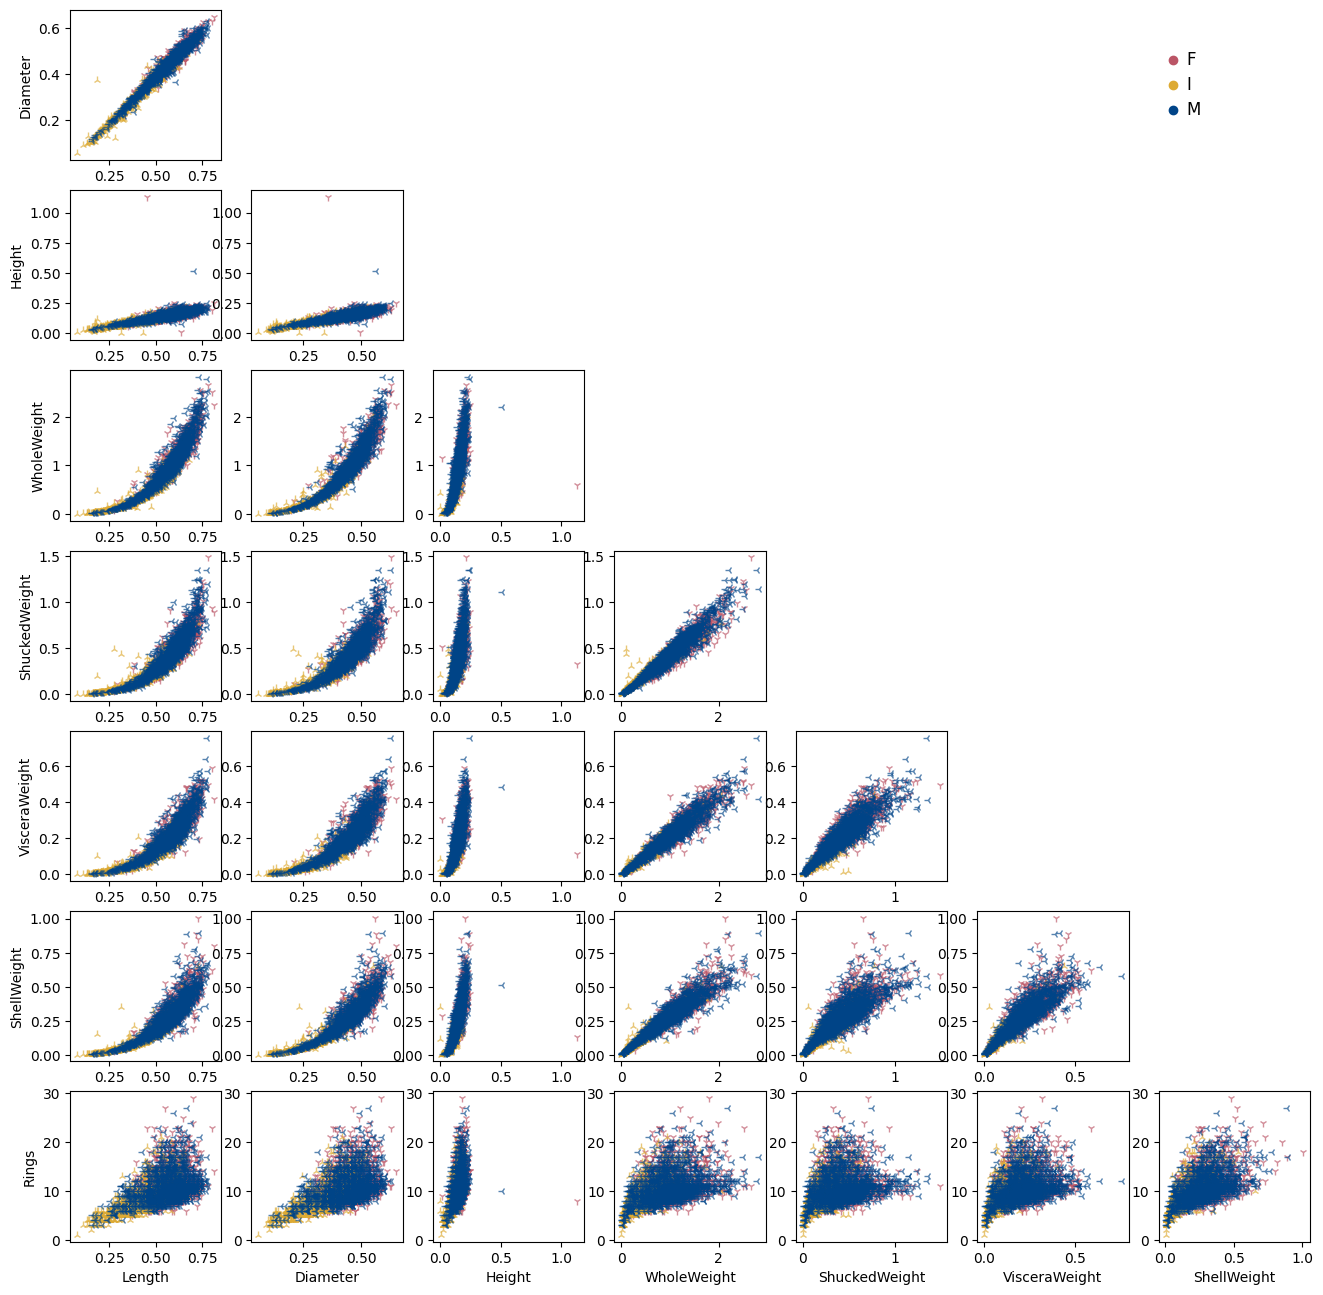

In [40]:
def plot_data():
    fig, axes = plt.subplots(natts-1, natts-1, figsize=(16,16))
    for xi, xname in enumerate(cnames[1:]):
        if xi > 0:
            axes[xi-1, 0].set_ylabel(xname)
        if xi < natts-1:
            axes[natts-2, xi].set_xlabel(xname)
        
        for yi, yname in enumerate(cnames[:xi]):
            for ci, cc in enumerate(classes):
                axes[xi-1, yi].plot(X[y==ci,yi], X[y==ci,xi], class_markers[ci], color=class_colors[ci], alpha=0.66)    
            if yi != xi-1:
                axes[yi, xi-1].axis('off')

    for ci, cc in enumerate(classes):
        axes[0, -1].scatter([0], [ci], color=class_colors[ci], cmap='Accent', vmin=0, vmax=3)
        axes[0, -1].text(0.1, ci, cc, verticalalignment='center', fontsize=12)
    axes[0, -1].set_xlim([-.1,1])
    axes[0, -1].set_ylim([len(classes)+1,-2])
    plt.show()

plot_data()

It is evident that the males have datapoints overlapping both infants and females, making the classification infeasible. It will be better to focus our classification task on females and infants, as they seem to separate: as analysed in the first python notebook, infants tend to have the lowest value of the attributes, and only when they grow do they get assigned a sex. Although males get assigned rather early, as is evident by the overlapping point clouds, females seems to get assigned much later. We can check this by plotting the same figure, excluding males.

Let's start by dropping the males from the dataset.

In [41]:
# Drop males
dtf = dtf_M.drop(dtf_M[dtf_M.Sex == 'M'].index)  # Drop rows with Sex=M

# Reload X, y, and classes
X = numpy.vstack([dtf[c] for c in cnames[1:]]).T  # cnames[1:] to avoid the Sex column
y = numpy.array(dtf[cnames[0]].rank(method='dense', ascending=True).astype(int)-1)  # cnames[0] for Sex
classes = sorted(set(dtf[cnames[0]]))
classes

['F', 'I']

Now let's plot the data again.

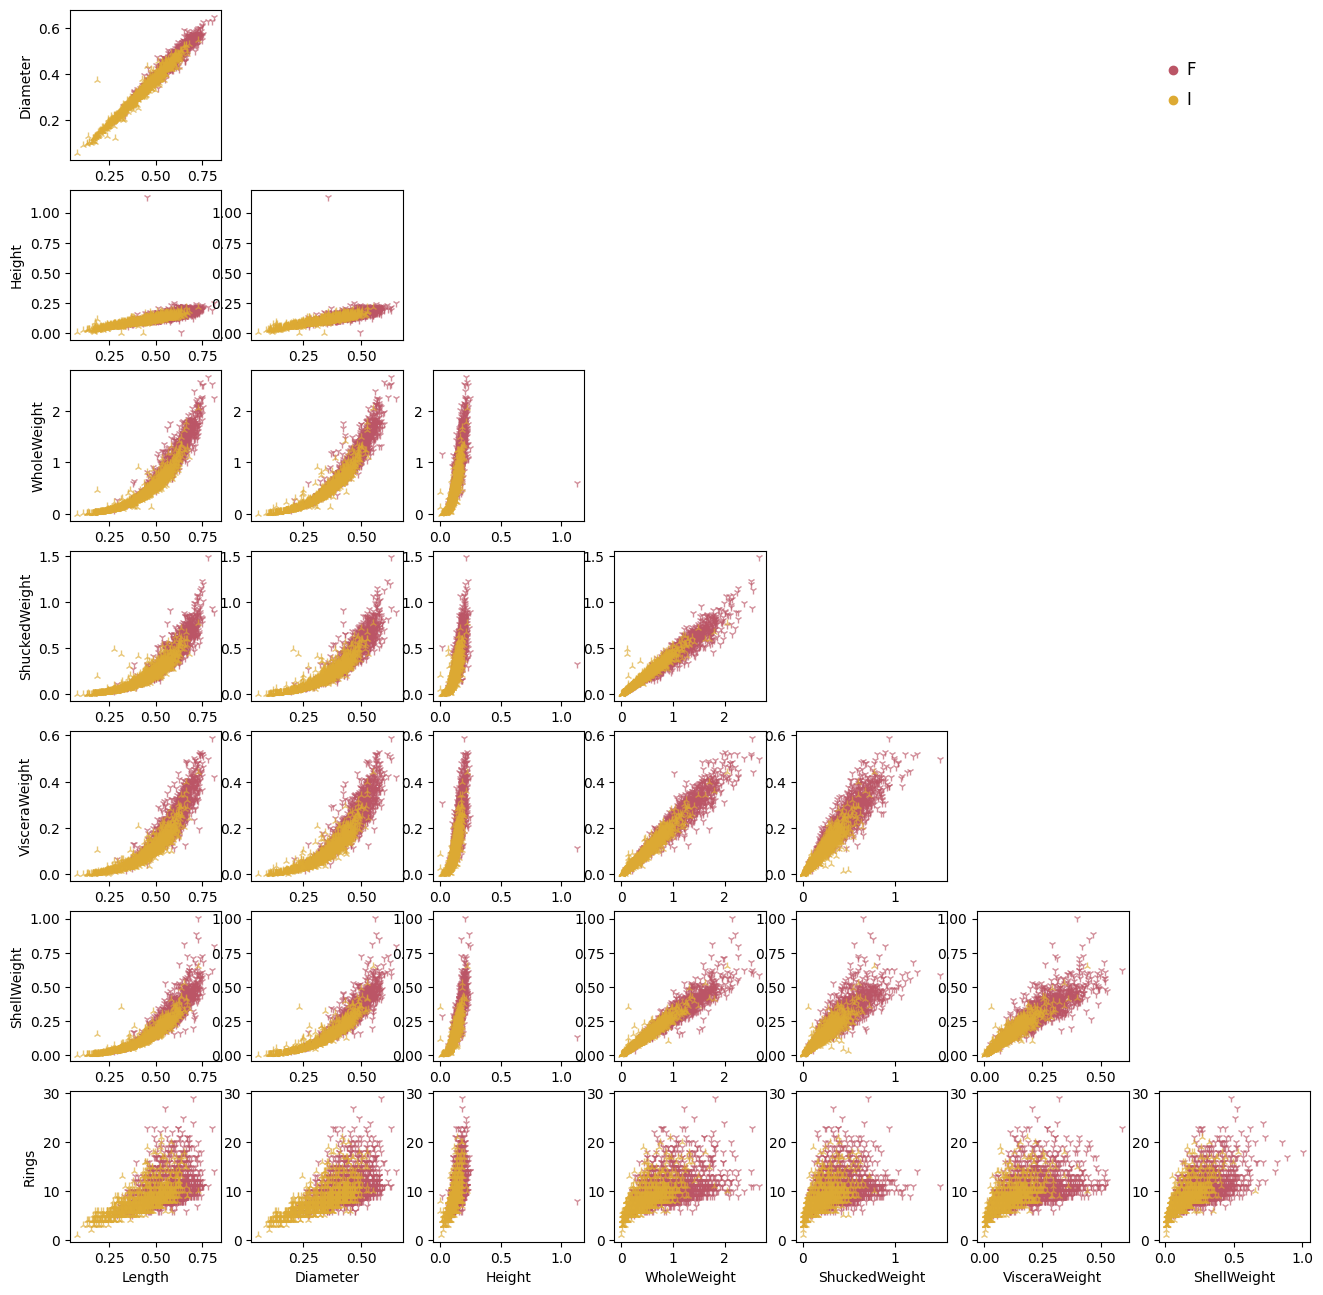

In [42]:
plot_data()

Unfortunately, there's still a lot of overlap with the datapoints, although the situation now is much better than before with the males involved. It'll be interesting to see how the different classifiers will handle the overlap problem and what the metric scores will look like.

## Binary classification 'Female' vs. Infant' using a decision tree

We can go straight to binary classification, as we've excluded our third class. We consider females `y=0` and infants `y=1`. Infants are considered the positive class.

First we prepare the data, splitting it into training and test subsets (in proportion 80%-20%).
We show the class labels of the test instances.

In [43]:
ratio_test = 0.2
idsC0 = numpy.random.permutation(numpy.where(y == 0)[0])
idsC1 = numpy.random.permutation(numpy.where(y == 1)[0])
nbC0_test = int(ratio_test * len(idsC0))
nbC1_test = int(ratio_test * len(idsC1))
ids01_test = numpy.concatenate((idsC0[:nbC0_test], idsC1[:nbC1_test]))
ids01_train = numpy.concatenate((idsC0[nbC0_test:], idsC1[nbC1_test:]))
X01_train = X[ids01_train, :]
y01_train = y[ids01_train]
X01_test = X[ids01_test, :]
y01_test = y[ids01_test]
y01_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

We setup a [decision tree classifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) with default parameters, fit it on the training subset, and generate the predictions for the test subset.

In [44]:
dt = tree.DecisionTreeClassifier()
dt = dt.fit(X01_train, y01_train)
y01_pred_dt = dt.predict(X01_test)
y01_pred_dt

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,

We compute the accuracy of the classifier on this task, i.e. the ratio of predicted class labels that match the ground truth.

In [45]:
metrics.accuracy_score(y01_test, y01_pred_dt)

0.7372400756143668

We compute the precision:

In [46]:
metrics.precision_score(y01_test, y01_pred_dt, pos_label=1)

0.7380073800738007

And the recall:

In [47]:
metrics.recall_score(y01_test, y01_pred_dt, pos_label=1)

0.746268656716418

Surprisingly, the metrics are not bad. Accuracy of over `0.7` means that the decision tree was able to correctly classify more than `70%` of the test instances. Both precision and recall are also higher than expected, despite the point cloud overlap. It's also worth noting that the metric values vary greatly with the different training and testing sets.

Next, we show a diagram of the learnt decision tree.

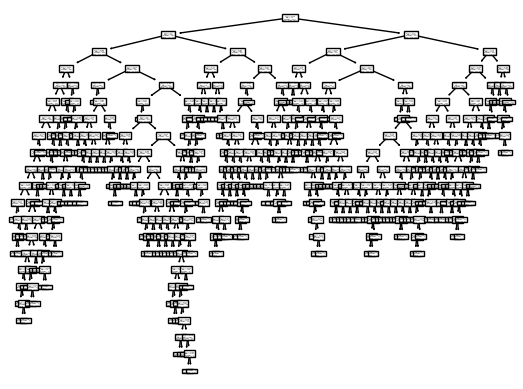

In [48]:
tree.plot_tree(dt)
plt.show()

Let's try the same train/test split, but with `criterion='entropy'`.

In [49]:
dtC = tree.DecisionTreeClassifier(criterion='entropy')
dtC = dtC.fit(X01_train, y01_train)
y01_pred_dtC = dtC.predict(X01_test)
y01_pred_dtC

array([0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,

Accuracy with `criterion='entropy'`:

In [50]:
metrics.accuracy_score(y01_test, y01_pred_dtC)

0.7485822306238186

Precision with `criterion='entropy'`:

In [51]:
metrics.precision_score(y01_test, y01_pred_dtC, pos_label=1)

0.7436823104693141

And recall with `criterion='entropy'`:

In [52]:
metrics.recall_score(y01_test, y01_pred_dtC, pos_label=1)

0.7686567164179104

We show a diagram of the learnt decision tree with `criterion='entropy'`:

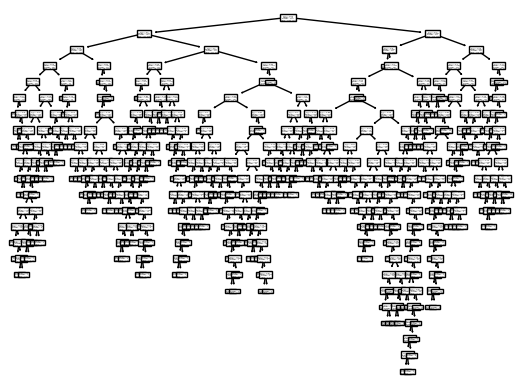

In [53]:
tree.plot_tree(dtC)
plt.show()

The tree is still very complex and the metrics didn't change much. Let's see what happens when we do the same with `min_samples_split=10`.

In [54]:
dtD = tree.DecisionTreeClassifier(criterion='entropy', min_samples_split=10)
dtD = dtD.fit(X01_train, y01_train)
y01_pred_dtD = dtD.predict(X01_test)
y01_pred_dtD

array([0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,

Accuracy with `min_samples_split=10`:

In [55]:
metrics.accuracy_score(y01_test, y01_pred_dtD)

0.7448015122873346

Precision with `min_samples_split=10`:

In [56]:
metrics.precision_score(y01_test, y01_pred_dtD, pos_label=1)

0.7509433962264151

And recall  with `min_samples_split=10`:

In [57]:
metrics.recall_score(y01_test, y01_pred_dtD, pos_label=1)

0.7425373134328358

We show a diagram of the learnt decision tree.

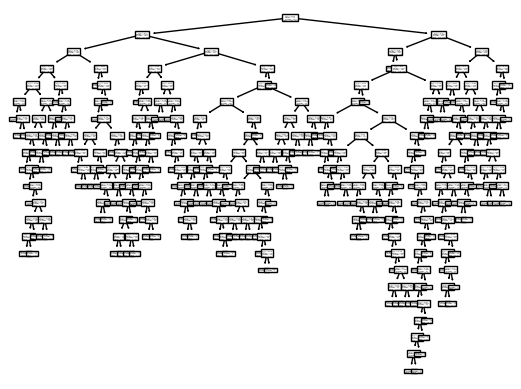

In [58]:
tree.plot_tree(dtD)
plt.show()

The metrics haven't changed much, and the tree still looks very complex. Let's try one more time, but with `min_samples_split=100`. The goal here is to avoid overfitting and aim for a less complex tree.

In [59]:
dtE = tree.DecisionTreeClassifier(criterion='entropy', min_samples_split=100)
dtE = dtE.fit(X01_train, y01_train)
y01_pred_dtE = dtE.predict(X01_test)
y01_pred_dtE

array([0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,

Accuracy with `min_samples_split=100`:

In [60]:
metrics.accuracy_score(y01_test, y01_pred_dtE)

0.7939508506616257

Precision with `min_samples_split=100`:

In [61]:
metrics.precision_score(y01_test, y01_pred_dtE, pos_label=1)

0.7890909090909091

And recall with `min_samples_split=100`:

In [62]:
metrics.recall_score(y01_test, y01_pred_dtE, pos_label=1)

0.8097014925373134

We show a diagram of the learnt decision tree with `min_samples_split=100`:

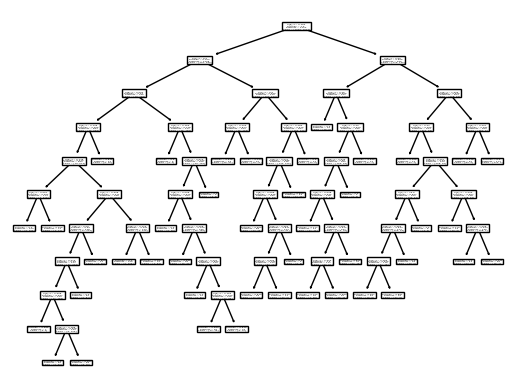

In [63]:
tree.plot_tree(dtE)
plt.show()

We're finally getting to readable decision tree, and the metrics seem to have improved overall.

Out of curiosity, let's do an extensive experiment with different values for `min_samples_split`. First, we create all the classifiers.

In [64]:
# Define the min_sample_split values
min_samples_splits = [i for i in range(2, 350, 20)]

# Create all the classifiers
dtF = [
    tree.DecisionTreeClassifier(criterion='entropy', min_samples_split=mss) 
    for mss in min_samples_splits
]

# Create the list of predictions
y01_pred_dtF = []

# Fit the classifiers
for dt in dtF:
    i = dtF.index(dt)  # Get the index of the current classifier
    dtF[i] = dt.fit(X01_train, y01_train)  # Fit the current classifier
    y01_pred_dtF.append(dt.predict(X01_test))  # Get the predictions for the current classifier

# Show the list of classifiers
dtF

[DecisionTreeClassifier(criterion='entropy'),
 DecisionTreeClassifier(criterion='entropy', min_samples_split=22),
 DecisionTreeClassifier(criterion='entropy', min_samples_split=42),
 DecisionTreeClassifier(criterion='entropy', min_samples_split=62),
 DecisionTreeClassifier(criterion='entropy', min_samples_split=82),
 DecisionTreeClassifier(criterion='entropy', min_samples_split=102),
 DecisionTreeClassifier(criterion='entropy', min_samples_split=122),
 DecisionTreeClassifier(criterion='entropy', min_samples_split=142),
 DecisionTreeClassifier(criterion='entropy', min_samples_split=162),
 DecisionTreeClassifier(criterion='entropy', min_samples_split=182),
 DecisionTreeClassifier(criterion='entropy', min_samples_split=202),
 DecisionTreeClassifier(criterion='entropy', min_samples_split=222),
 DecisionTreeClassifier(criterion='entropy', min_samples_split=242),
 DecisionTreeClassifier(criterion='entropy', min_samples_split=262),
 DecisionTreeClassifier(criterion='entropy', min_samples_spli

Now we calculate the metrics for all the classifiers.

In [65]:
# Dict of metrics. Each item is a list of values for each metric: accuracy `a`, precision `p` and recall `r`
dtF_metrics = {
    'a': [],
    'p': [],
    'r': []
}

# Loop through the predictions
for y_pred in y01_pred_dtF:
    # Calculate metrics
    m_acc = metrics.accuracy_score(y01_test, y_pred)
    m_prec = metrics.precision_score(y01_test, y_pred, pos_label=1)
    m_recall = metrics.recall_score(y01_test, y_pred, pos_label=1)

    # Append results into the list of metrics
    dtF_metrics['a'].append(m_acc)
    dtF_metrics['p'].append(m_prec)
    dtF_metrics['r'].append(m_recall)


# Show the metrics
dtF_metrics

{'a': [0.7542533081285444,
  0.782608695652174,
  0.7863894139886578,
  0.8034026465028355,
  0.7996219281663516,
  0.7939508506616257,
  0.7977315689981096,
  0.7958412098298677,
  0.7958412098298677,
  0.7958412098298677,
  0.8034026465028355,
  0.7996219281663516,
  0.7996219281663516,
  0.8071833648393195,
  0.8071833648393195,
  0.8071833648393195,
  0.8071833648393195,
  0.8071833648393195],
 'p': [0.7429577464788732,
  0.7865168539325843,
  0.7838827838827839,
  0.7847222222222222,
  0.78125,
  0.7890909090909091,
  0.8014981273408239,
  0.8007518796992481,
  0.8007518796992481,
  0.8007518796992481,
  0.8253968253968254,
  0.81640625,
  0.81640625,
  0.8487394957983193,
  0.8487394957983193,
  0.8487394957983193,
  0.8487394957983193,
  0.8487394957983193],
 'r': [0.7873134328358209,
  0.7835820895522388,
  0.7985074626865671,
  0.8432835820895522,
  0.8395522388059702,
  0.8097014925373134,
  0.7985074626865671,
  0.7947761194029851,
  0.7947761194029851,
  0.7947761194029851,

Let's plot the metrics for a better view.

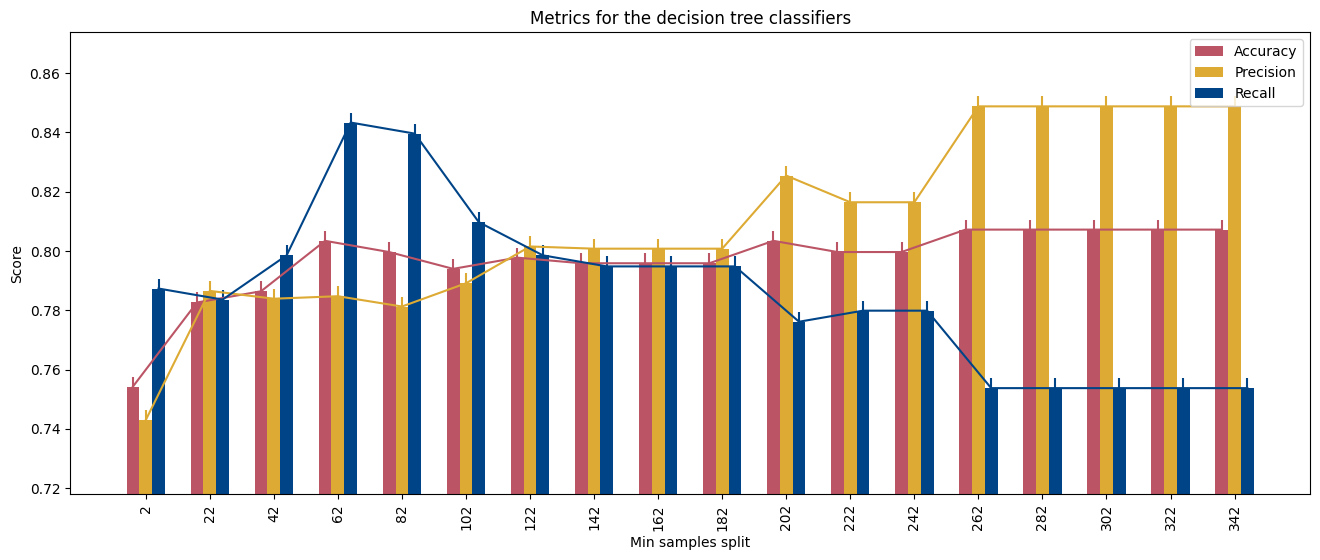

In [66]:
# Setup
plt.figure(figsize=(16,6))
X_axis = numpy.arange(len(dtF))
width = 0.2
colors = ['#BB5566', '#DDAA33', '#004488']

# Get the minimum and max values
minmax_metrics = []
minmax_metrics.extend([
    min(dtF_metrics['a']), max(dtF_metrics['a']),
    min(dtF_metrics['p']), max(dtF_metrics['p']),
    min(dtF_metrics['r']), max(dtF_metrics['r'])
    ]
)
y_min = min(minmax_metrics)
y_max = max(minmax_metrics)
offset = 0.025

# Plot bars
b1 = plt.bar(X_axis-width, height=dtF_metrics['a'], width=width, label='Accuracy', color=colors[0])
b2 = plt.bar(X_axis, height=dtF_metrics['p'], width=width, label='Precision', color=colors[1])
b3 = plt.bar(X_axis+width, height=dtF_metrics['r'], width=width, label='Recall', color=colors[2])

# # Plot lines
l1 = plt.plot(X_axis-width, dtF_metrics['a'], color=colors[0])
l2 = plt.plot(X_axis, dtF_metrics['p'], color=colors[1])
l3 = plt.plot(X_axis+width, dtF_metrics['r'], color=colors[2])

# # Plot scatter (for the dots)
s1 = plt.scatter(X_axis-width, dtF_metrics['a'], color=colors[0], s=200, marker='|')
s2 = plt.scatter(X_axis, dtF_metrics['p'], color=colors[1], s=200, marker='|')
s3 = plt.scatter(X_axis+width, dtF_metrics['r'], color=colors[2], s=200, marker='|')

# Finishing up the plotting
ax = plt.gca()
ax.set_ylim([y_min - offset, y_max + offset])
plt.xlabel("Min samples split")
plt.xticks(X_axis, min_samples_splits, rotation='vertical')
plt.ylabel("Score")
plt.title("Metrics for the decision tree classifiers")
plt.legend((b1, b2, b3), ('Accuracy', 'Precision', 'Recall'))
plt.show()

From previous experiments, it's noticeable that the metrics don't change for `min_samples_split > 300` no matter how much the value increases (tested until `min_samples_split = 1002`). In this iteration (values might change due to random seed!), we notice that the best metrics are:
- accuracy: `0.8261` at `min_samples_split = 222`;
- precision: `0.8701` at `min_samples_split = [282, +inf]`;
- recall: `0.8172` at `min_samples_split = [42, 62]`.

Also, it is very noticeable that we have a sudden drop in recall between `min_samples_split = [182, 262]`, going as low as `0.7351`, which then jumps to its stable value at `min_samples_split = 302`.

We can see that increasing the value from the default already gives a bump in metrics, most likely to avoid a certain degree of overfitting. The sudden drop in recall is strange, and it rises a bit before going into its stable value. An ideal value of `min_samples_split` is likely going to be in the center of the graph, after the rise from overfitting fix, and before the sudden recall drop.

Let's plot all the trees for comparison (the more trees, the longer it takes to plot! Usually around 1min to plot all).

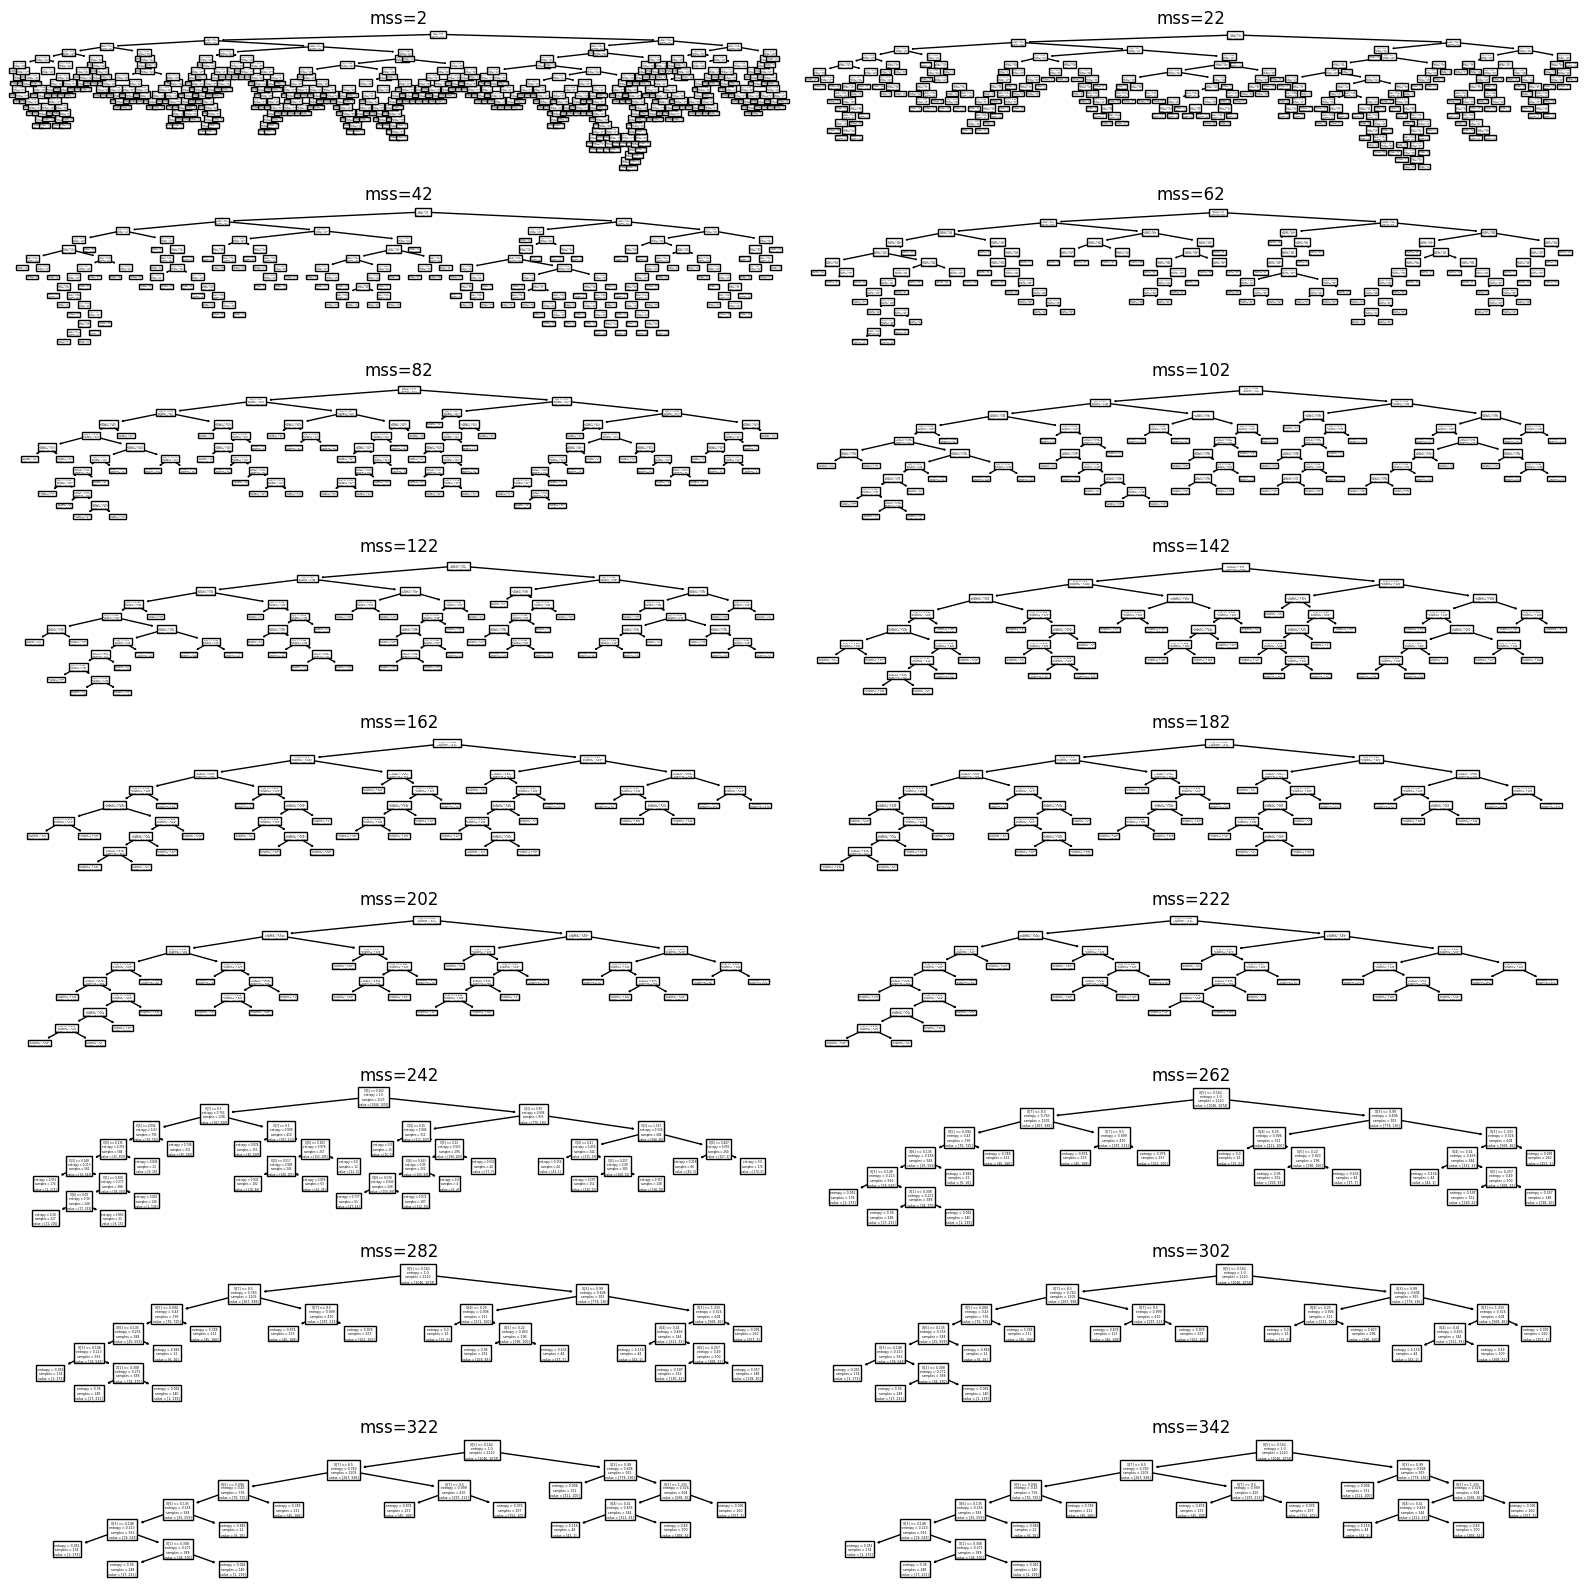

In [67]:
# Settings
nrows = round(len(dtF)/2)
ncols = 2
figsize = [16, 16]

# Setup
fig = plt.figure(figsize=figsize)
i = 1

# Plots
for dt in dtF:
    ax = fig.add_subplot(nrows, ncols, i)  # Add a subplot
    tree.plot_tree(dt)  # Plot the current tree
    ax.set_title(f'mss={min_samples_splits[i-1]}')  # Add title
    i += 1

plt.tight_layout()
plt.show()


## Ternary classification involving the 'Male' sex with a decision tree

Earlier in the notebook, we concluded from the pointcloud distribution that the overlapping from `Sex=Male` would make classification unfeasible. Let's check that theory by evaluating a ternary classification and see how well (or how bad) the classifier performs.

`criterion='entropy', min_samples_split=100` are the used parameters.

In [68]:
X_M = numpy.vstack([dtf_M[c] for c in cnames[1:]]).T  # cnames[1:] to avoid the Sex column
y_M = numpy.array(dtf_M[cnames[0]].rank(method='dense', ascending=True).astype(int)-1)  # cnames[0] for Sex

ratio_test = 0.2
idsC0_M = numpy.random.permutation(numpy.where(y == 0)[0])
idsC1_M = numpy.random.permutation(numpy.where(y == 1)[0])
idsC2_M = numpy.random.permutation(numpy.where(y == 2)[0])
nbC0_test_M = int(ratio_test * len(idsC0_M))
nbC1_test_M = int(ratio_test * len(idsC1_M))
nbC2_test_M = int(ratio_test * len(idsC2_M))
ids012_test = numpy.concatenate((idsC0_M[:nbC0_test_M], idsC1_M[:nbC1_test_M], idsC2_M[:nbC2_test_M]))
ids012_train = numpy.concatenate((idsC0_M[nbC0_test_M:], idsC1_M[nbC1_test_M:], idsC2_M[nbC2_test_M:]))
X012_train = X_M[ids012_train, :]
y012_train = y_M[ids012_train]
X012_test = X_M[ids012_test, :]
y012_test = y_M[ids012_test]

dtT = tree.DecisionTreeClassifier(criterion='entropy', min_samples_split=100)
dtT = dtT.fit(X012_train, y012_train)
y012_pred_dtT = dtT.predict(X012_test)

The accuracy is:

In [69]:
metrics.accuracy_score(y012_test, y012_pred_dtT)

0.4877126654064272

Decision tree:

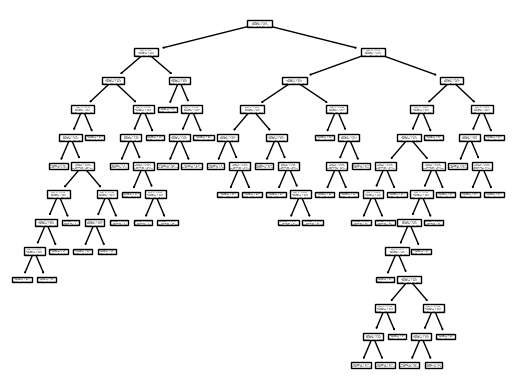

In [70]:
tree.plot_tree(dtT)
plt.show()

As expected, the accuracy is low, with values around `0.5`. It is likely that the `Male` sex classification is significantly lowering the accuracy score, and that the decision tree is getting some `Female` and `Infant` classifications right, as they're the most dintinguished pointclouds.

## Binary classification 'Female' vs. Infant' using a support vector machine (SVM)

Let's go back to the `Female` vs `Infant` classification task, this time with a SVM.

We setup a [linear support vector classifier](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) with default parameters, fit it on the training subset, and generate the predictions for the test subset.

In [71]:
sv = svm.LinearSVC()
sv = sv.fit(X01_train, y01_train)
y01_pred_sv = sv.predict(X01_test)
y01_pred_sv

c:\Users\fabia\Documents\_imlex\uef\Introduction to Algorithmic Data Analysis\assignments\.env\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


array([0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,

We compute the accuracy of the classifier on this task.

In [72]:
metrics.accuracy_score(y01_test, y01_pred_sv)

0.8090737240075614

We compute the precision.

In [73]:
metrics.precision_score(y01_test, y01_pred_sv, pos_label=1)

0.8014440433212996

And the recall.

In [74]:
metrics.recall_score(y01_test, y01_pred_sv, pos_label=1)

0.8283582089552238

As there is overlap between the `Female` and `Infant` classes, we expect the metrics to be imperfect. Nonetheless, the obtained values are high, around `0.85` for all the metrics with the default parameters for the SVM.

Next, we try with a polynomial kernel of degree 3.

In [75]:
svB = svm.SVC(kernel='poly', degree=3)
svB = svB.fit(X01_train, y01_train)
y01_pred_svB = svB.predict(X01_test)
y01_pred_svB

array([0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,

We compute the accuracy for `kernel='poly', degree=3`.

In [76]:
metrics.accuracy_score(y01_test, y01_pred_svB)

0.7901701323251418

We compute the precision for `kernel='poly', degree=3`.

In [77]:
metrics.precision_score(y01_test, y01_pred_svB, pos_label=1)

0.7643097643097643

And the recall for `kernel='poly', degree=3`.

In [78]:
metrics.recall_score(y01_test, y01_pred_svB, pos_label=1)

0.8470149253731343

With the polynomial kernel of degree 3, we get slightly worse accuracy and precision, but higher recall.

Finally, we train a linear SVM, but in just two dimensions, i.e. only on attributes `WholeWeight` and `ShuckedWeight`.

In [79]:
svC = svm.SVC(kernel='linear')
svC = svC.fit(X01_train[:,[3,4]], y01_train)
y01_pred_svC = svC.predict(X01_test[:,[3,4]])
y01_pred_svC

array([0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,

We compute the accuracy of the classifier on this task.

In [80]:
metrics.accuracy_score(y01_test, y01_pred_svC)

0.7977315689981096

We compute the precision.

In [81]:
metrics.precision_score(y01_test, y01_pred_svC, pos_label=1)

0.784452296819788

And the recall.

In [82]:
metrics.recall_score(y01_test, y01_pred_svC, pos_label=1)

0.8283582089552238

Now let's plot the results.

Training instances are depicted as small squares, whereas test instances are depicted as larger circles, with the inner part colored according to the ground-truth class and the outer part according to the predicted class.

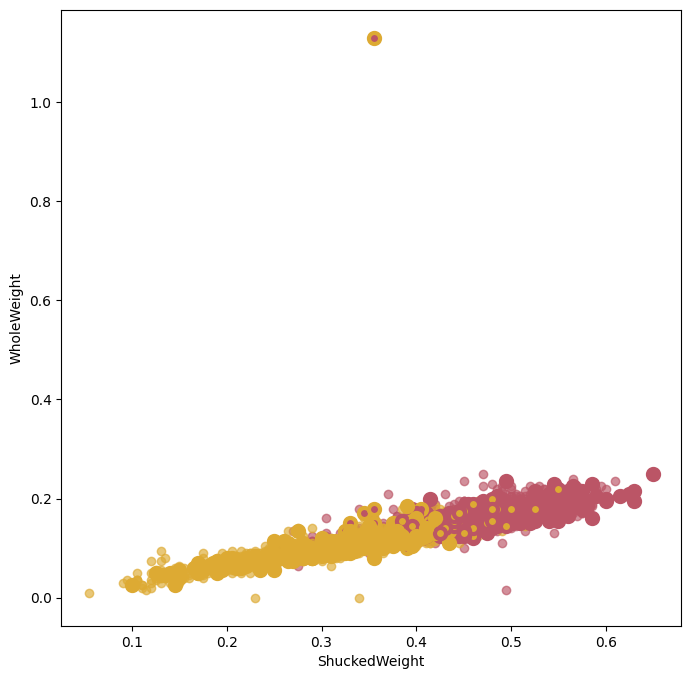

In [83]:
fig, axes = plt.subplots(1, 1, figsize=(8,8))
for ci, cc in enumerate(classes):
    plt.plot(X01_train[y01_train==ci,1], X01_train[y01_train==ci,2], 
             '.', markersize=12, color=class_colors[ci], alpha=0.66)
for i, x in enumerate(X01_test):
    plt.plot(x[1], x[2], 'o', markersize=8, markeredgewidth=3,
             markerfacecolor=class_colors[y01_test[i]], markeredgecolor=class_colors[y01_pred_svC[i]])
plt.ylabel(cnames[4])
plt.xlabel(cnames[5])
plt.show()

Not much of a different in terms of metrics, but it's interesting to see in the plot which points were wrongly classified, despite all the overlapping.

## Additional remarks

I tried using the `dtreeviz` package to better visualize the decision trees, but couldn't get it to work in my virtual environment, likely due to the system PATH being different from where I installed the software.
- https://mljar.com/blog/visualize-decision-tree/ under the `Plot Decision Tree with dtreeviz Package` section
- https://graphviz.org/download/

External resources: 

- https://www.geeksforgeeks.org/plotting-multiple-bar-charts-using-matplotlib-in-python/
- https://mljar.com/blog/visualize-decision-tree/
- https://stackoverflow.com/questions/11159436/multiple-figures-in-a-single-window
- https://www.youtube.com/watch?v=AwLRMcH5zz8

No collaborations.